<a href="https://colab.research.google.com/github/Gumball12/malicious-url-detection/blob/main/malicious_url_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download dataset (dataset from https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset)
! git clone https://github.com/Gumball12/malicious-url-detection

# install deps
! pip install nltk sklearn pandas matplotlib seaborn

Cloning into 'malicious-url-detection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# define constants
data_dir = './malicious-url-detection/malicious_phish.csv'
test_ratio = 0.2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# dataset
df = pd.read_csv(data_dir)
print(df.head())

train_df, test_df = train_test_split(
    df,
    test_size=test_ratio,
    random_state=40
)

train_labels = train_df['type']
test_labels = test_df['type']

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


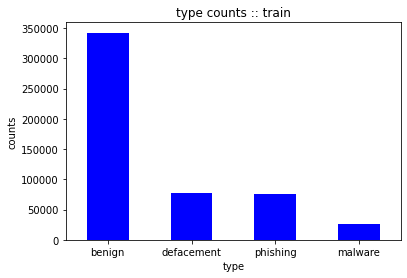

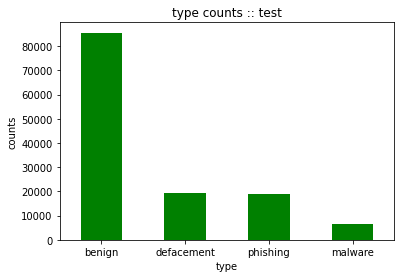

In [14]:
# data visulization
def visualize(df, typeName, color='brg'):
  cnt_types = pd.value_counts(df['type'])
  cnt_types.plot(kind='bar', colormap=color)

  plt.title('type counts :: ' + typeName)
  plt.xticks(rotation='horizontal')
  plt.xlabel('type')
  plt.ylabel('counts')
  plt.show()

visualize(train_df, 'train')
visualize(test_df, 'test', color='ocean')

In [22]:
# tokenization
def tokenizer(url):
  tokens = re.split('[/-]', url)
  
  for token in tokens:
    if token.find('.') >= 0:
      dot_split = token.split('.')

      if 'com' in dot_split:
        dot_split.remove('com')

      if 'www' in dot_split:
        dot_split.remove('www')

      tokens += dot_split

  return tokens

example_url = df['url'][1]
print('origin: {}'.format(example_url))

example_tokenized = tokenizer(example_url)
print('tokenized: {}'.format(example_tokenized))

origin: mp3raid.com/music/krizz_kaliko.html
tokenized: ['mp3raid.com', 'music', 'krizz_kaliko.html', 'mp3raid', 'krizz_kaliko', 'html']


In [34]:
# vectorization
count_vec = CountVectorizer(tokenizer=tokenizer)
tfidf_vec = TfidfVectorizer(tokenizer=tokenizer)

example_count_X = count_vec.fit_transform([example_url])
example_tfidf_X = tfidf_vec.fit_transform([example_url])
print('count vectorization: {}'.format(example_count_X))
print('tfidf vectorization: {}'.format(example_tfidf_X))

train_count_X = count_vec.fit_transform(train_df['url'])
train_tfidf_X = tfidf_vec.fit_transform(train_df['url'])

test_count_X = count_vec.transform(test_df['url'])
test_tfidf_X = tfidf_vec.transform(test_df['url'])

count vectorization:   (0, 4)	1
  (0, 5)	1
  (0, 2)	1
  (0, 3)	1
  (0, 1)	1
  (0, 0)	1
tfidf vectorization:   (0, 0)	0.4082482904638631
  (0, 1)	0.4082482904638631
  (0, 3)	0.4082482904638631
  (0, 2)	0.4082482904638631
  (0, 5)	0.4082482904638631
  (0, 4)	0.4082482904638631


In [43]:
# define reporter
def report(cmatrix, score, creport):
  cmatrix = cmatrix.T

  plt.figure(figsize=(5, 5))

  sns.heatmap(
      cmatrix,
      annot=True,
      fmt='d',
      linewidths=0.5,
      square=True,
      xticklabels=['bening', 'defacement', 'malware', 'phishing'],
      yticklabels=['bening', 'defacement', 'malware', 'phishing']
  )

  plt.xticks(rotation='horizontal')
  plt.yticks(rotation='horizontal')
  plt.xlabel('actual')
  plt.ylabel('pred')
  plt.title('accuracy score: {}'.format(score))

  print(creport)
  plt.show()

              precision    recall  f1-score   support

      benign       0.87      1.00      0.93     85605
  defacement       0.99      0.97      0.98     19384
     malware       1.00      0.88      0.93      6380
    phishing       0.98      0.38      0.55     18870

    accuracy                           0.90    130239
   macro avg       0.96      0.81      0.85    130239
weighted avg       0.91      0.90      0.88    130239



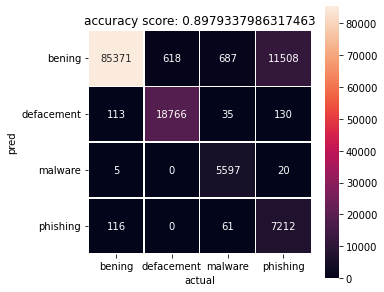

In [44]:
# train & eval mnb-tfidf
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(train_tfidf_X, train_labels)

score_mnb_tfidf = mnb_tfidf.score(test_tfidf_X, test_labels)
pred_mnb_tfidf = mnb_tfidf.predict(test_tfidf_X)
cmatrix_mnb_tfidf = confusion_matrix(test_labels, pred_mnb_tfidf)
creport_mnb_tfidf = classification_report(test_labels, pred_mnb_tfidf)

report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)

              precision    recall  f1-score   support

      benign       0.92      0.98      0.95     85605
  defacement       0.94      0.99      0.97     19384
     malware       0.99      0.93      0.96      6380
    phishing       0.89      0.57      0.70     18870

    accuracy                           0.92    130239
   macro avg       0.93      0.87      0.89    130239
weighted avg       0.92      0.92      0.91    130239



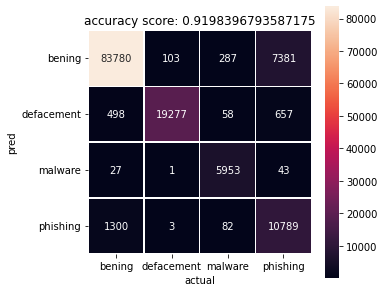

In [45]:
# train & eval mnb-count
mnb_count = MultinomialNB()
mnb_count.fit(train_count_X, train_labels)

score_mnb_count = mnb_count.score(test_count_X, test_labels)
pred_mnb_count = mnb_count.predict(test_count_X)
cmatrix_mnb_count = confusion_matrix(test_labels, pred_mnb_count)
creport_mnb_count = classification_report(test_labels, pred_mnb_count)

report(cmatrix_mnb_count, score_mnb_count, creport_mnb_count)

              precision    recall  f1-score   support

      benign       0.93      0.98      0.96     85605
  defacement       0.93      1.00      0.96     19384
     malware       0.99      0.95      0.97      6380
    phishing       0.93      0.64      0.76     18870

    accuracy                           0.94    130239
   macro avg       0.94      0.89      0.91    130239
weighted avg       0.94      0.94      0.93    130239



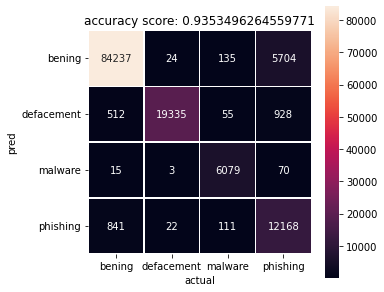

In [48]:
# train & eval lgs-tfidf
lgs_tfidf = LogisticRegression(solver='sag')
lgs_tfidf.fit(train_tfidf_X, train_labels)

score_lgs_tfidf = lgs_tfidf.score(test_tfidf_X, test_labels)
pred_lgs_tfidf = lgs_tfidf.predict(test_tfidf_X)
cmatrix_lgs_tfidf = confusion_matrix(test_labels, pred_lgs_tfidf)
creport_lgs_tfidf = classification_report(test_labels, pred_lgs_tfidf)

report(cmatrix_lgs_tfidf, score_lgs_tfidf, creport_lgs_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


              precision    recall  f1-score   support

      benign       0.94      0.99      0.96     85605
  defacement       0.99      1.00      0.99     19384
     malware       0.99      0.96      0.98      6380
    phishing       0.93      0.69      0.79     18870

    accuracy                           0.95    130239
   macro avg       0.96      0.91      0.93    130239
weighted avg       0.95      0.95      0.94    130239



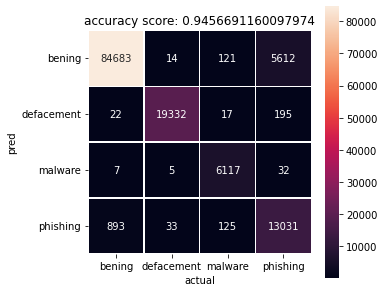

In [49]:
# train & eval lgs-count
lgs_count = LogisticRegression(solver='sag')
lgs_count.fit(train_count_X, train_labels)

score_lgs_count = lgs_count.score(test_count_X, test_labels)
pred_lgs_count = lgs_count.predict(test_count_X)
cmatrix_lgs_count = confusion_matrix(test_labels, pred_lgs_count)
creport_lgs_count = classification_report(test_labels, pred_lgs_count)

report(cmatrix_lgs_count, score_lgs_count, creport_lgs_count)